In [22]:
x=[[5,7,8],[6,3],[3],[1]]

In [23]:
import helpers

In [24]:
#xt is the current matrix. xlen is each column's length
#all defined under numpy
xt,xlen = helpers.batch(x)

In [102]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
sess = tf.InteractiveSession()


Encoder starts with empty state and runs through the input sequence. We are not interested in encoder's outputs, only in its final_state.
Decoder uses encoder's final_state as its initial_state. Its inputs are a batch-sized matrix with <EOS> token at the 1st time step and <PAD> at the following. 

This kind of encoder-decoder is forced to learn fixed-length representation (specifically, hidden_units size) of the variable-length input sequence and restore output sequence only from this representation.

In [103]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

In [104]:
#define tf.placeholder for tf's input and output
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [105]:
#decoder_input
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

# Embeddings
First we initialize embedding matrix. Initializations are random. We rely on our end-to-end training to learn vector representations for words jointly with encoder and decoder.

In [106]:
embeddings = tf.Variable(tf.truncated_normal([vocab_size, input_embedding_size], mean=0.0, stddev=0.1), dtype=tf.float32)

In [107]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

# Encoder


We discard encoder_outputs because we are not interested in them within seq2seq framework. What we actually want is encoder_final_state — state of LSTM's hidden cells at the last moment of the Encoder rollout.

encoder_final_state is also called "thought vector". We will use it as initial state for the Decoder. In seq2seq without attention this is the only point where Encoder passes information to Decoder. We hope that backpropagation through time (BPTT) algorithm will tune the model to pass enough information throught the thought vector for correct sequence output decoding.


In [108]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

del encoder_outputs

In [109]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>)

TensorFlow LSTM implementation stores state as a tuple of tensors.
- encoder_final_state.h is activations of hidden layer of LSTM cell
- encoder_final_state.c is final output, which can potentially be transfromed with some wrapper 

# Decoder

In [110]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,

    initial_state=encoder_final_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [111]:
# connect with softmax layer
decoder_logits = tf.contrib.layers.fully_connected(decoder_outputs, vocab_size)

#output the max value in the so called_time stamp
decoder_prediction = tf.argmax(decoder_logits, 2)

In [112]:
decoder_prediction

<tf.Tensor 'ArgMax:0' shape=(?, ?) dtype=int64>

# Optimizer

In [113]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [114]:
sess.run(tf.global_variables_initializer())

### Test forward pass

In [115]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[3 3 3]
 [3 3 3]
 [2 2 2]
 [2 2 2]]


### Training

In [116]:
batch_size = 100

# batches is a generator
batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

In [117]:
temp = next(batches)
a = temp[:1]
print a
print helpers.batch([(sequence) + [EOS] for sequence in a])

[[5, 4, 3]]
(array([[5],
       [4],
       [3],
       [1]], dtype=int32), [4])


Given encoder_inputs [5, 6, 7], decoder_targets would be [5, 6, 7, 1], where 1 is for EOS, and decoder_inputs would be [1, 5, 6, 7] - decoder_inputs are lagged by 1 step, passing previous token as input at current step.

In [118]:
def next_feed():
    batch = next(batches)
    #batch help change the current list into a new format
    #check above
    encoder_inputs_, _ = helpers.batch(batch)
    #add eos to last row
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [119]:
print min(loss_track)

0.0419861


In [120]:
loss_track = []

In [121]:
max_batches = 10001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        if l<0.04:
            break
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.30795192719
  sample 1:
    input     > [4 9 6 0 0 0 0 0]
    predicted > [7 7 7 7 2 2 2 2 2]
  sample 2:
    input     > [8 3 8 3 2 9 7 2]
    predicted > [3 3 3 3 3 3 2 0 3]
  sample 3:
    input     > [7 5 9 4 9 0 0 0]
    predicted > [3 0 3 9 9 9 2 2 2]
()
batch 1000
  minibatch loss: 0.506815254688
  sample 1:
    input     > [8 7 5 6 7 3 0 0]
    predicted > [5 5 5 3 7 3 1 0 0]
  sample 2:
    input     > [6 7 5 9 2 0 0 0]
    predicted > [6 7 5 9 2 1 0 0 0]
  sample 3:
    input     > [8 3 7 8 5 9 6 4]
    predicted > [3 7 7 4 5 9 6 4 1]
()
batch 2000
  minibatch loss: 0.210689276457
  sample 1:
    input     > [3 8 6 6 8 2 8 0]
    predicted > [3 6 6 6 8 2 8 1 0]
  sample 2:
    input     > [6 6 4 0 0 0 0 0]
    predicted > [6 6 4 1 0 0 0 0 0]
  sample 3:
    input     > [4 3 6 5 0 0 0 0]
    predicted > [4 3 6 5 1 0 0 0 0]
()
batch 3000
  minibatch loss: 0.174735739827
  sample 1:
    input     > [4 4 9 0 0 0 0 0]
    predicted > [4 4 9 1 0 0 0 0 0]

loss 0.1137 after 1000100 examples (batch_size=100)


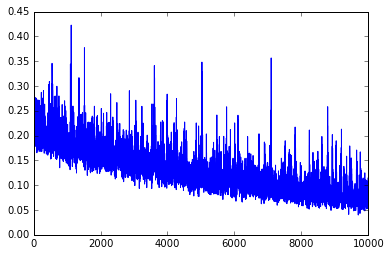

In [94]:
#如果不加上%maplotlib inline 的话，每次figure的显示都需要plt.show();

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))